In [1]:
import ipywidgets as widgets

# Avoid non-compliant Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # pylint: disable=wrong-import-position

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact
from IPython.display import display
from tqdm.notebook import tqdm

import utils

In [2]:
csv_val = pd.read_csv('FYP_config.csv')

In [3]:
label_dict = {}
label_to_value = {}
for index, row in csv_val.iterrows():
    label_dict[row['Trained_model']] =  row['Label']
    label_to_value[row['Label']] = row['Trained_model']

In [4]:
print(label_dict)

{'20220215T231623912054-pushing_4-small_divider-ours-original': 'DQN Small obstacle + no spatial intent', '20220215T063413269718-pushing_4-small_divider-ours-original-no-spatial-intent_900000': 'DDPG Small obstacle + no spatial intent + 900000', '20220215T063413269718-pushing_4-small_divider-ours-original-no-spatial-intent_600000': 'DDPG Small obstacle + no spatial intent + 600000', '20220215T063413269718-pushing_4-small_divider-ours-original-no-spatial-intent': 'DDPG Small obstacle + no spatial intent', '20220215T232034418645-pushing_4-small_divider-ours-original': 'DQN Big obstacle + no spatial intent', '20220214T203627985598-pushing_4-small_divider-ours-original-no-spatial-intent': 'DDPG Big obstacle + no spatial intent', '20220212T195909602578-pushing_4-small_divider-ours-original': 'DDPG equal distribution + OU exploration + spatial intent + big obstacle', '20220212T175537990040-pushing_4-small_divider-ours-original': 'DDPG equal distribution + epsilon exploration + spatial intent

In [5]:
pd.set_option('display.max_rows', None)
plt.rcParams['figure.figsize'] = (12, 8)

In [6]:
logs_dir = utils.get_logs_dir()
eval_dir = utils.get_eval_dir()
env_names = ['small_empty', 'small_divider', 'large_empty', 'large_doors', 'large_tunnels', 'large_rooms']
step_size = 100

In [7]:
# Load all runs
cfgs = [utils.load_config(str(x / 'config.yml')) for x in tqdm(sorted(logs_dir.iterdir())) if x.is_dir()]

In [8]:
def extend_curves(curves, min_len=None):
    if len(curves) == 0:
        return curves
    max_length = max(len(curve) for curve in curves)
    if min_len is not None:
        max_length = max(max_length, min_len)
    for i, curve in enumerate(curves):
        curves[i] = np.pad(curve, (0, max_length - len(curve)), 'edge')
    return curves

In [9]:
def get_ratio(cfg):
    avg = 0 
    try: 
        eval_path = eval_dir / '{}_ratio.npy'.format(cfg.run_name)        
        print(eval_path)
        datas = np.load(eval_path, allow_pickle=True)
        temp_lis = []
        for data in datas: 
            print(data)
            if(data[0] < 1): 
                print(abs(data[0]*10-1),data[0])
                #avg += abs(5 - data[0]*10)
            else: 
                print(abs(data[0]-1),data[0])
                #avg+= abs(5-data[0])
            temp_lis.append(data[0])
            #else: 
            #print(data[0])
            #avg+= data[0]
        print(avg/len(datas))
        avg = sum(temp_lis) / len(temp_lis)
        var = sum((x-avg)**2 for x in temp_lis) / len(temp_lis)
        print(temp_lis)
        print(var)
    except: 
        pass

In [10]:
def get_curve_for_run(cfg):
    eval_path = eval_dir / '{}.npy'.format(cfg.run_name)
    data = np.load(eval_path, allow_pickle=True)
    
    curves = []
    for episode in data:
        cubes = np.asarray([step['cubes'] for step in episode])
        simulation_steps = np.array([step['simulation_steps'] for step in episode])
        x = np.arange(0, simulation_steps[-1] + step_size, step_size)
        xp, fp = simulation_steps, cubes
        curves.append(np.floor(np.interp(x, xp, fp, left=0)))
    return np.mean(extend_curves(curves), axis=0)

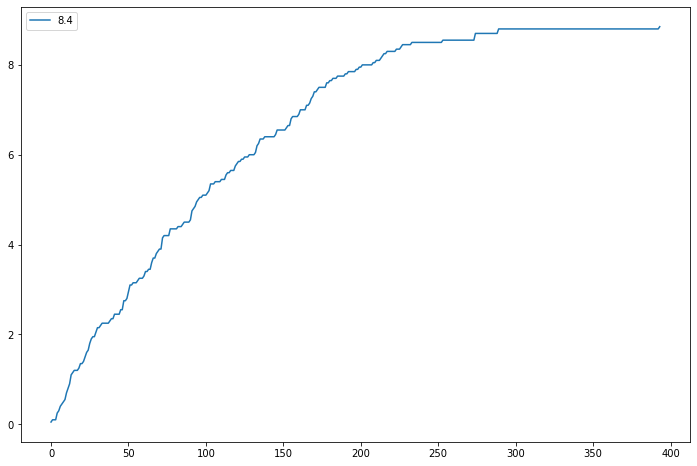

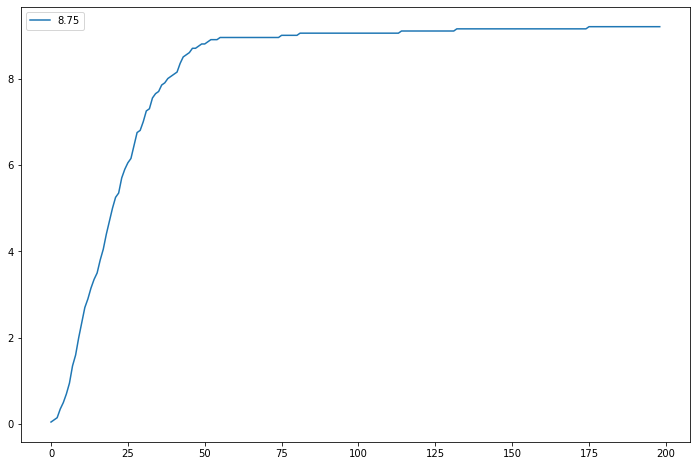

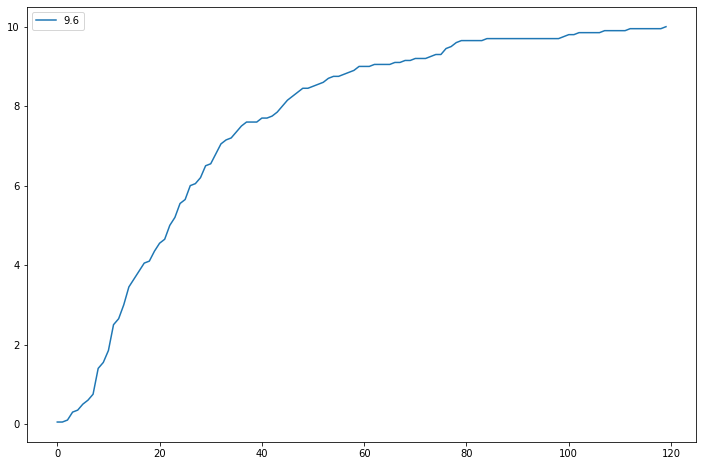

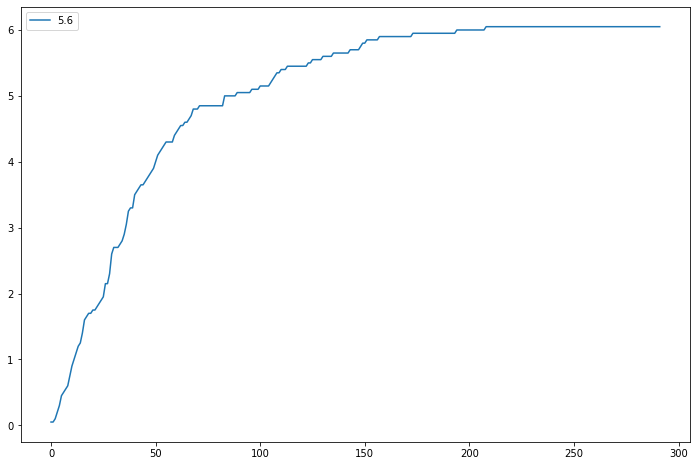

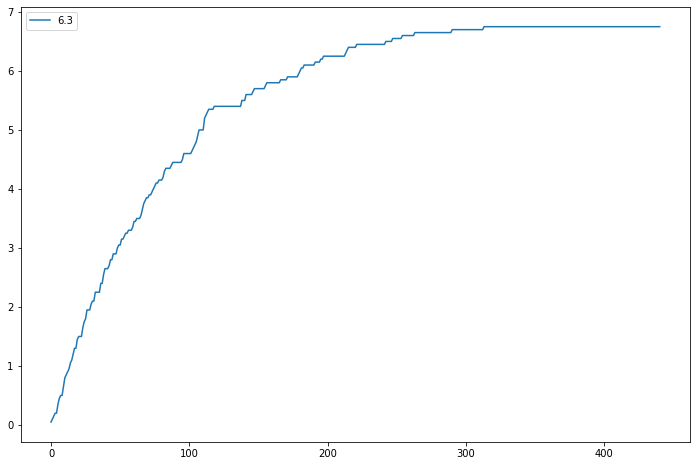

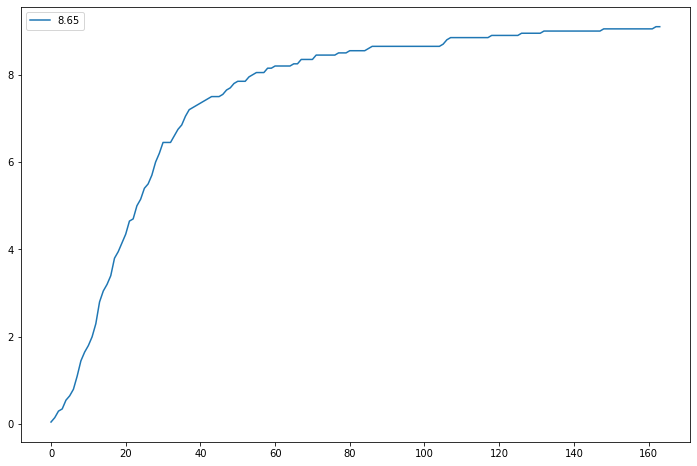

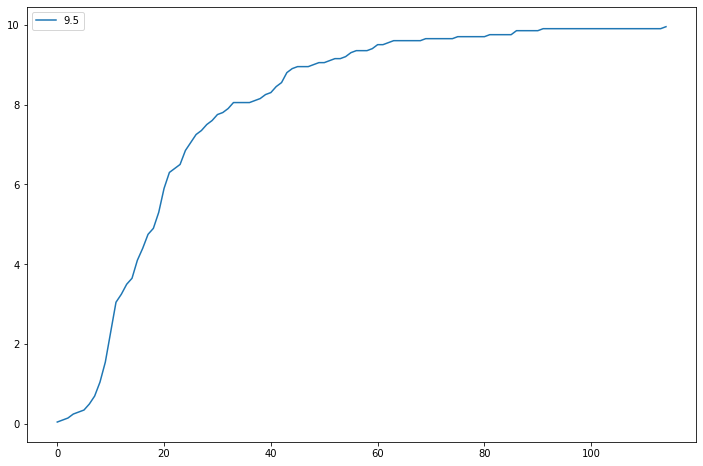

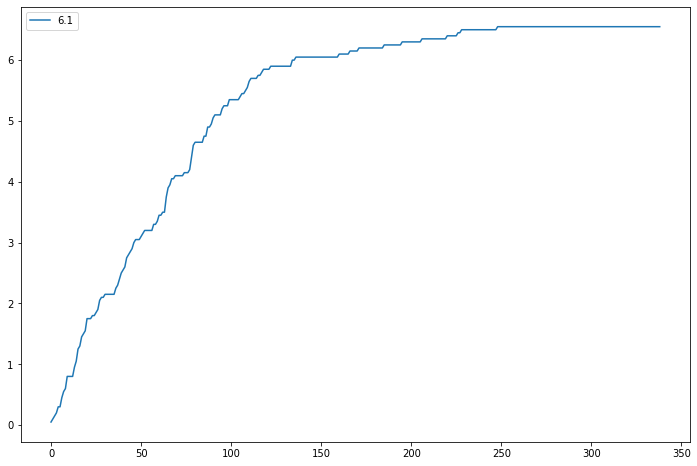

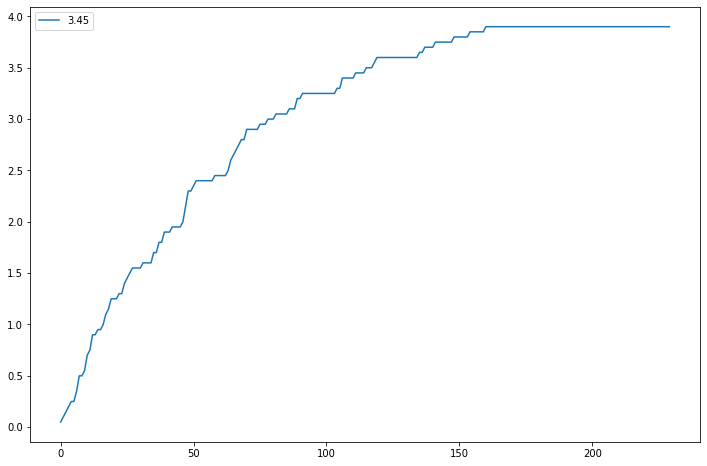

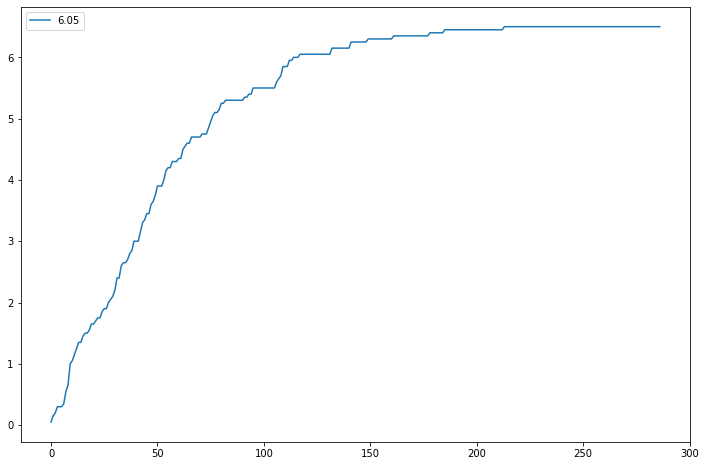

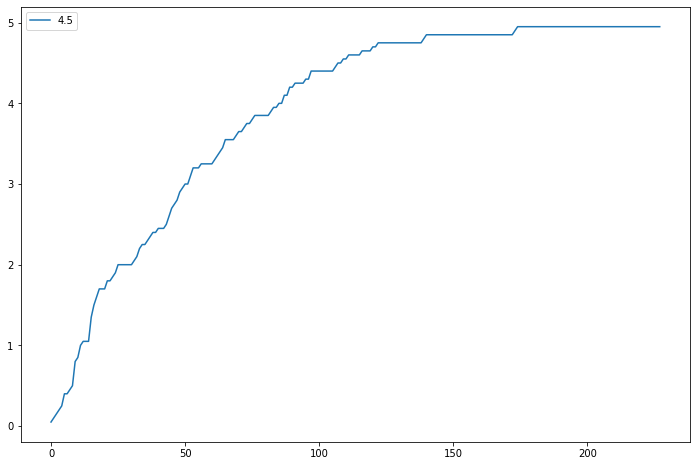

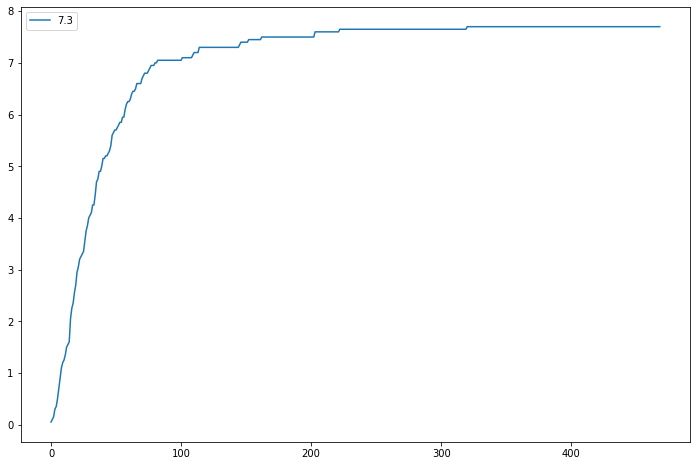

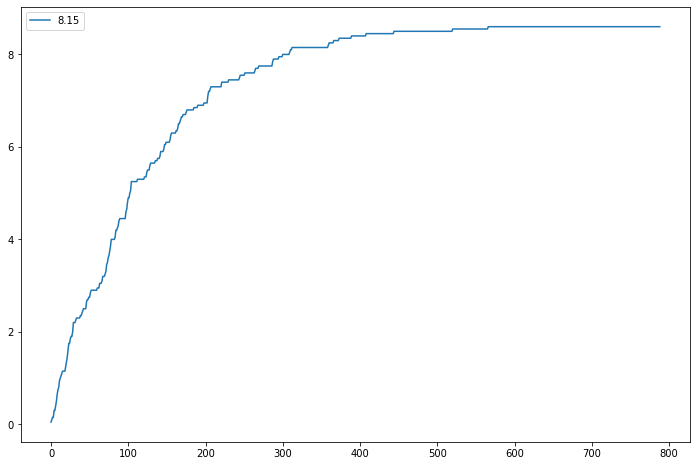

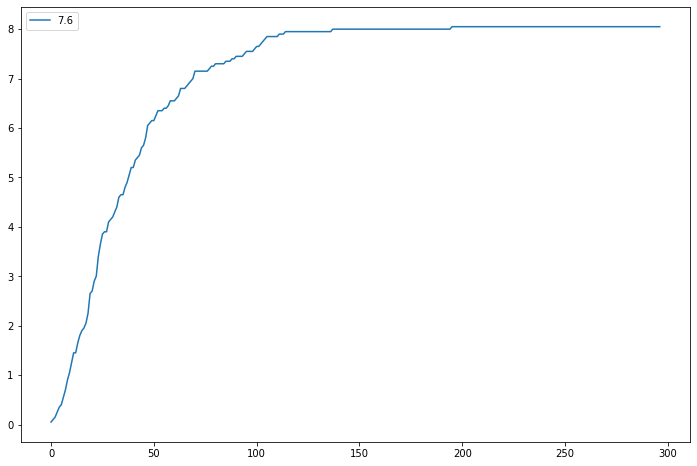

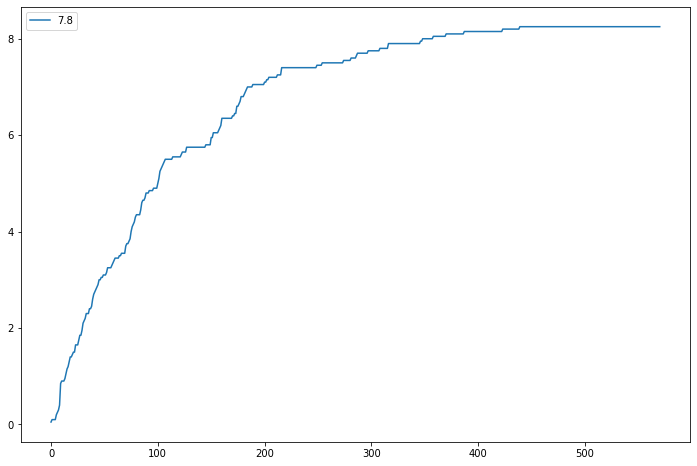

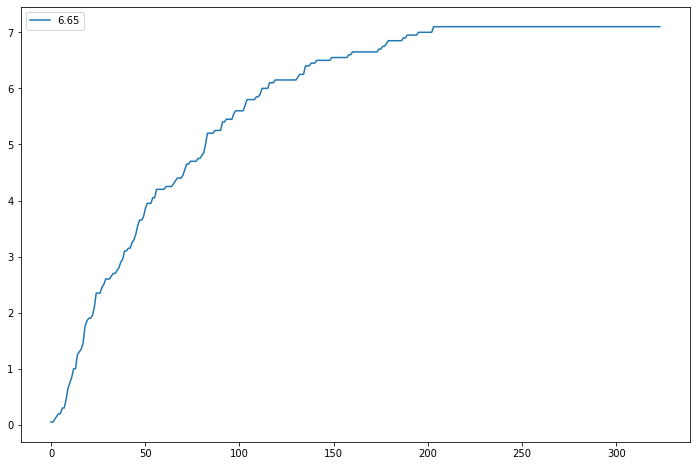

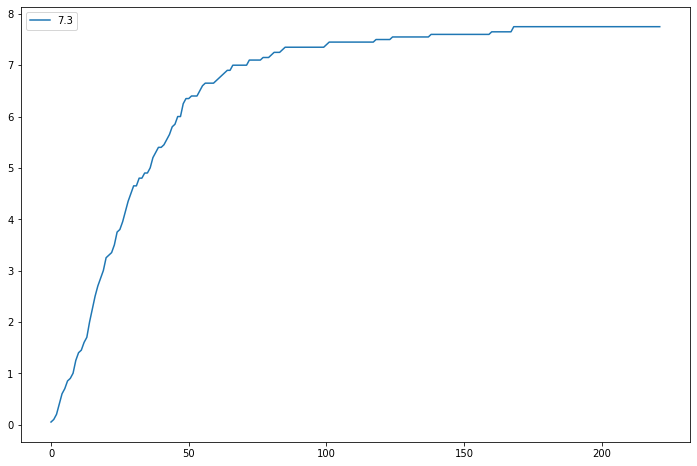

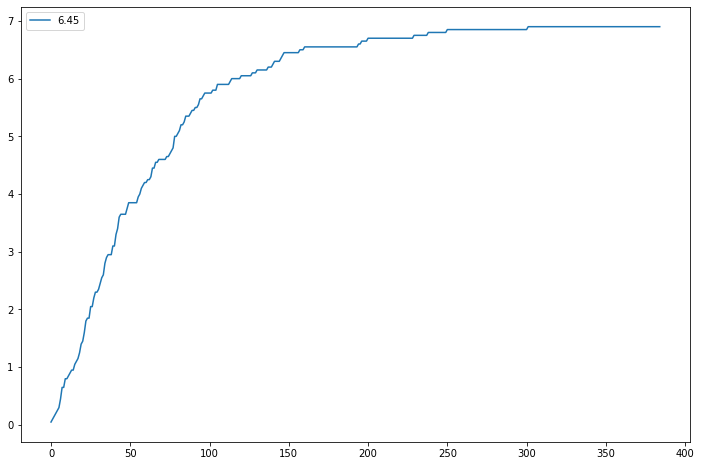

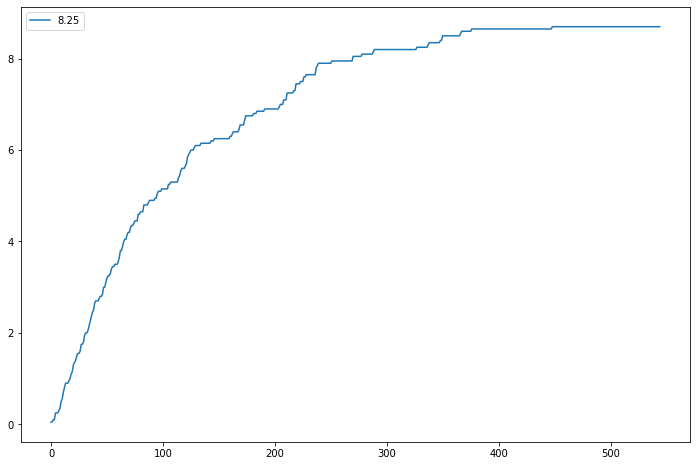

{'eval/20220214T073008624913-pushing_4-small_empty-ours-original-no-spatial-intent.npy': [],
 'eval/20220206T091919243765-pushing_4-small_empty-original-closest_cube_map-closest_cube_reward.npy': [],
 'eval/20220210T122929070500-pushing_4-small_empty-ours-original.npy': [],
 'eval/20220210T132353041911-pushing_4-small_divider-ours.npy': [],
 'eval/20220213T074646744431-pushing_4-small_divider-ours-original.npy': [],
 'eval/20220206T091840181213-pushing_4-small_empty-ours-original.npy': [],
 'eval/20220206T214553725194-pushing_4-small_empty-ours-original.npy': [],
 'eval/20220213T180107299669-pushing_4-small_divider-no-spatial-map-closest_cube_map-closest_cube_reward.npy': [],
 'eval/20220211T233918690407-pushing_4-small_divider-ours-original.npy': [],
 'eval/20220212T175537990040-pushing_4-small_divider-ours-original.npy': [],
 'eval/20220212T195909602578-pushing_4-small_divider-ours-original.npy': [],
 'eval/20220210T123640424463-pushing_4-small_divider-ours-original.npy': [],
 'eval/

In [24]:
import glob
eval_directory = glob.glob("eval/*")

def get_curve_for_run_temp(eval_path):
    
    data = np.load(eval_path, allow_pickle=True)
    
    curves = []
    for episode in data:
        cubes = np.asarray([step['cubes'] for step in episode])
        simulation_steps = np.array([step['simulation_steps'] for step in episode])
        x = np.arange(0, simulation_steps[-1] + step_size, step_size)
        xp, fp = simulation_steps, cubes
        curves.append(np.floor(np.interp(x, xp, fp, left=0)))
        
    y_mean = np.mean(extend_curves(curves), axis=0)
    this_len = np.searchsorted(y_mean > y_mean[-1] - 0.5, True)  # Subtract 0.5 since interpolated curves are continuous
    c2 = np.mean(extend_curves(curves, min_len=(this_len + 1)),axis=0)
    return np.mean(extend_curves(curves), axis=0),c2[this_len]
def get_all_curves_temp():
    all_curves = {}
    for evals in eval_directory: 
        if("ratio" not in evals ): 
            experiment_name = evals
            if experiment_name not in all_curves:
                all_curves[experiment_name] = []
            curve,ending_val =  get_curve_for_run_temp(evals)
            plt.plot(curve,label=str(ending_val))
            plt.legend()
            plt.show()
            
            #all_curves[experiment_name].append(get_curve_for_run_temp(evals))
            
    return all_curves
get_all_curves_temp()

In [157]:
data_for_comparison = {}
def get_all_curves():
    global data_for_comparison
    all_curves = {}
    for cfg in tqdm(cfgs):
        print("doing",cfg.checkpoint_dir.split("/")[1])
        experiment_name = cfg.checkpoint_dir.split("/")[1]
        if(cfg.env_name not in data_for_comparison): 
            data_for_comparison[cfg.env_name] = [experiment_name]
        else: 
            data_for_comparison[cfg.env_name].append(experiment_name)
        
        if experiment_name not in all_curves:
            all_curves[experiment_name] = []
        get_ratio(cfg)
        all_curves[experiment_name].append(get_curve_for_run(cfg))
    return all_curves

In [158]:
all_curves = get_all_curves()

doing 20220212T175537990040-pushing_4-small_divider-ours-original
eval/20220212T175537990040-pushing_4-small_divider-ours-original_ratio.npy
[1 5]
0 1
[0 5]
1 0
[1 5]
0 1
[1 5]
0 1
[4 5]
3 4
[1 2]
0 1
[1 5]
0 1
[3 5]
2 3
[4 4]
3 4
[4 1]
3 4
[2 5]
1 2
[2 5]
1 2
[2 5]
1 2
[3 5]
2 3
[4 5]
3 4
[3 5]
2 3
[3 2]
2 3
[1 2]
0 1
[5 4]
4 5
[1 4]
0 1
0.0
[1, 0, 1, 1, 4, 1, 1, 3, 4, 4, 2, 2, 2, 3, 4, 3, 3, 1, 5, 1]
1.9100000000000001
doing 20220212T195909602578-pushing_4-small_divider-ours-original
eval/20220212T195909602578-pushing_4-small_divider-ours-original_ratio.npy
[1 3]
0 1
[2 2]
1 2
[2 3]
1 2
[2 5]
1 2
[3 5]
2 3
[0 0]
1 0
[1 4]
0 1
[3 3]
2 3
[3 4]
2 3
[1 0]
0 1
[1 3]
0 1
[1 2]
0 1
[2 4]
1 2
[4 4]
3 4
[1 5]
0 1
[3 5]
2 3
[1 4]
0 1
[0 4]
1 0
[1 1]
0 1
[1 5]
0 1
0.0
[1, 2, 2, 2, 3, 0, 1, 3, 3, 1, 1, 1, 2, 4, 1, 3, 1, 0, 1, 1]
1.1275
doing 20220213T073359978229-pushing_4-small_divider-ours-original
eval/20220213T073359978229-pushing_4-small_divider-ours-original_ratio.npy
[2 5]
1 2
[4 5]
3 4
[

In [159]:
def get_all_cutoffs():
    all_cutoffs = {}
    for cfg in tqdm(cfgs):
        robot_config_str = cfg.experiment_name.split('-')[0]
        print(robot_config_str)
        experiment_name = cfg.checkpoint_dir.split("/")[1]
        robot_config_str  = experiment_name
        if robot_config_str not in all_cutoffs:
            all_cutoffs[robot_config_str] = {}
        if cfg.env_name not in all_cutoffs[robot_config_str]:
            all_cutoffs[robot_config_str][cfg.env_name] = float('inf')

        # Find the time at which the last cube was successfully foraged
        y_mean = np.mean(extend_curves(all_curves[experiment_name]), axis=0)
        this_len = np.searchsorted(y_mean > y_mean[-1] - 0.5, True)  # Subtract 0.5 since interpolated curves are continuous
        all_cutoffs[robot_config_str][cfg.env_name] = min(all_cutoffs[robot_config_str][cfg.env_name], this_len)
    return all_cutoffs

In [160]:
all_cutoffs = get_all_cutoffs()

pushing_4
pushing_4
pushing_4
pushing_4
pushing_4
pushing_4
pushing_4
pushing_4
pushing_4
pushing_4
pushing_4
pushing_4
pushing_4
pushing_4
pushing_4
pushing_4
pushing_4
pushing_4
pushing_4
pushing_4
pushing_4



In [161]:
def get_all_results():
    all_results = {}
    for cfg in tqdm(cfgs):
        experiment_name = cfg.checkpoint_dir.split("/")[1]
        robot_config_str = cfg.experiment_name.split('-')[0]
        robot_config_str  = experiment_name
        if robot_config_str not in all_results:
            all_results[robot_config_str] = {}
        cutoff = all_cutoffs[robot_config_str][cfg.env_name]
        curves = extend_curves(all_curves[experiment_name], min_len=(cutoff + 1))
        cubes = [curve[cutoff] for curve in curves]
        all_results[robot_config_str][experiment_name] = '{:.2f} ± {:.2f}'.format(np.mean(cubes), np.std(cubes))
    return all_results

In [162]:
all_results = get_all_results()

In [163]:
def show_table():
    def f(robot_config_str):
        data = {'performance': all_results[robot_config_str]}
        display(pd.DataFrame(data))

    robot_config_str_dropdown = widgets.RadioButtons(options=sorted(all_results.keys()))
    interact(f, robot_config_str=robot_config_str_dropdown)

In [164]:
# Note: These metrics measure relative performance, see show_curves() for plots of absolute performance
show_table()

interactive(children=(RadioButtons(description='robot_config_str', options=('20220212T175537990040-pushing_4-s…

In [165]:
def show_curves():
    def plot_curves(experiment_names, env_name, fontsize=20):
        experiment_names = list(experiment_names)
        i = 0 
        while(i< len(experiment_names)): 
            
            experiment_names[i] = label_to_value[experiment_names[i]]
            i+=1
        max_simulation_step = 0 
        print(len(all_curves[experiment_names[0]][0]))
        
        max_length = max(len(all_curves[experiment_name][0]) for experiment_name in experiment_names)
        
        for experiment_name in experiment_names: 
            
            curve = all_curves[experiment_name][0]
            all_curves[experiment_name][0] = np.pad(curve, (0, max_length - len(curve)), 'edge')
         
        for experiment_name in experiment_names:
            # Plot cutoff
            robot_config_str = experiment_name.split('-')[0]
            robot_config_str = experiment_name
            
            #best_len = all_cutoffs[robot_config_str][env_name]
            #plt.axvline(best_len * step_size, linewidth=1, c='r')
           
            # Plot curve
            curves = extend_curves(all_curves[experiment_name])
            x = np.arange(0, (len(curves[0]) - 0.5) * step_size, step_size)
            y_mean, y_std = np.mean(curves, axis=0), np.std(curves, axis=0)
            label = '{} ({})'.format(label_dict[experiment_name], all_results[robot_config_str][experiment_name])
            plt.plot(x, y_mean, label=label)
            plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2)

        num_cubes = 20 if env_name.startswith('large') else 10
        
        plt.xlim(0)
        
        plt.ylim(0, num_cubes+1)
        plt.xticks(fontsize=fontsize - 2)
        plt.yticks(range(0, num_cubes + 1, 2), fontsize=fontsize - 2)
        plt.xlabel('Simulation Steps', fontsize=fontsize)
        plt.ylabel('Num Objects', fontsize=fontsize)
        plt.legend(fontsize=fontsize - 2)

    def f(env_name, experiment_names):
        
        if len(experiment_names) == 0:
            return
        print("chosen", experiment_names)
        #tuple(data_for_comparison[env_name])
        plot_curves( experiment_names,env_name)
        plt.show()

    env_name_radio = widgets.RadioButtons(options=env_names)
    experiment_names_select = widgets.SelectMultiple(layout=widgets.Layout(width='60%', height='150px'))
    def update_experiment_names_options(*_):
        matching_experiment_names = []
        matching_experiment_names_2 = []
        for experiment_name in sorted(all_curves):
            if env_name_radio.value in experiment_name:
                matching_experiment_names.append(experiment_name)
                matching_experiment_names_2.append(label_dict[experiment_name])
        experiment_names_select.options = matching_experiment_names_2
        experiment_names_select.rows = len(matching_experiment_names)
        experiment_names_select.value = ()
    env_name_radio.observe(update_experiment_names_options)
    interact(f, env_name=env_name_radio, experiment_names=experiment_names_select)

In [166]:

# Note: The vertical red line is used to measure relative performance, the curves show absolute performance
show_curves()

interactive(children=(RadioButtons(description='env_name', options=('small_empty', 'small_divider', 'large_emp…